# Training Script 
This notebook uses the different algorithms for training

In [1]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

2024-06-17 22:40:13.476840: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-17 22:40:13.499971: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 22:40:14.666570: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-17 22:40:14.669828: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bu

(256, 256, 4) (512, 512, 1)
(256, 256, 4) (512, 512, 1)
(256, 256, 4) (512, 512, 1)
(256, 256, 4) (512, 512, 1)
(256, 256, 4) (512, 512, 1)
(256, 256, 4) (512, 512, 1)
(256, 256, 4) (512, 512, 1)
(256, 256, 4) (512, 512, 1)


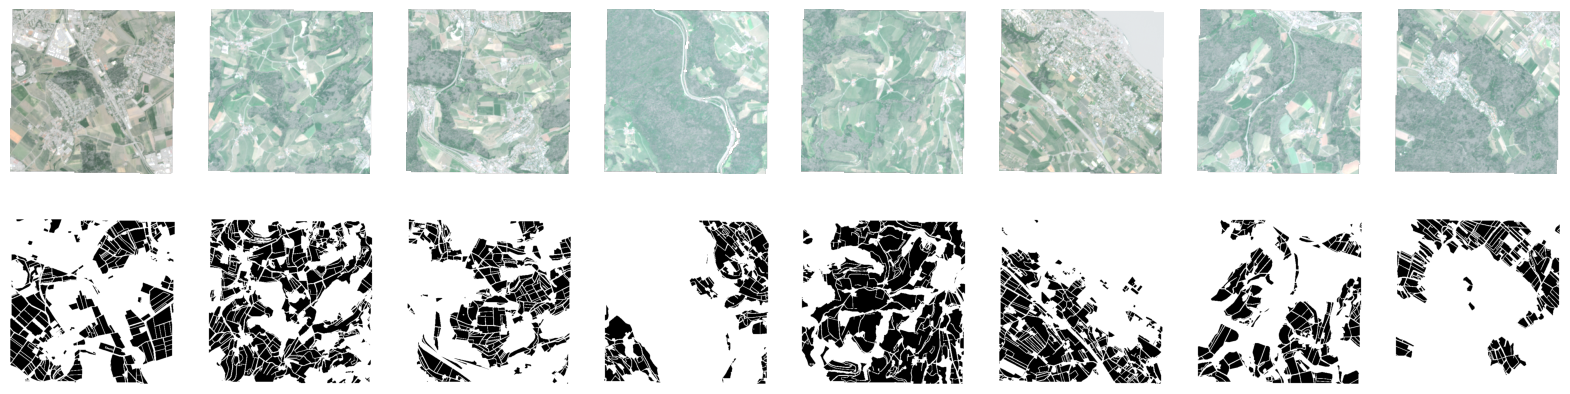

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

def plot_images(images, masks, num_images=8):
    fig, ax = plt.subplots(2, num_images, figsize=(20, 5))
    for i in range(num_images):
        ax[0, i].imshow(images[i])
        ax[0, i].axis('off')
        ax[1, i].imshow(masks[i].squeeze(), cmap='gray')
        ax[1, i].axis('off')
    plt.show()
    
path = "/workspaces/Satelite/data/dataset_upscaled_False/train"
train_data = tf.data.Dataset.load(path)

# Load the images and masks
images = []
masks = []

for image, mask in train_data.take(8):
    print(image.shape, mask.shape)
    images.append(image.numpy())
    masks.append(mask.numpy())

# Plot the images and masks
plot_images(images, masks, num_images=8)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from helpers.load import LoadandAugment
from models import model

input_shape = (256,256,4)
UNET = model.Deep_Attention_RESUNET(input_shape, NUM_CLASSES=1, dropout_rate=0, batch_norm=True)

# Base path for the dataset
path = "/workspaces/Satelite/data/dataset_upscaled_False"
train_path = os.path.join(path, "train")
val_path = os.path.join(path, "val")
test_path = os.path.join(path, "test")

# Initialize data loaders with correct target shape
train_data = LoadandAugment(train_path, "train", 8, True)
val_data = LoadandAugment(val_path, "val", 8, True)

# Initialize UNET model with correct input shape
UNET.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=['accuracy'])

# Setup the model checkpoint callback to save the best model
checkpoint_callback = ModelCheckpoint(
    'best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min'
)

# Train the model
UNET.fit(
    train_data.dataset, 
    validation_data=val_data.dataset, 
    epochs=100, 
    callbacks=[checkpoint_callback]
)

Model: "AttentionResUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  2368        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                  

KeyboardInterrupt: 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import tensorflow as tf
import rasterio
from rasterio.transform import from_origin
from helpers.load import LoadandAugment

# Base path for the dataset
path = "/workspaces/Satelite/data/dataset_upscaled_False"
test_path = os.path.join(path, "test")

#  Load the test file mapping
with open('/workspaces/Satelite/data/dataset_upscaled_False/test_file_mapping.json', 'r') as f:
    test_file_mapping = json.load(f)

def plot_predictions(images, masks, predictions, num=6):
    plt.figure(figsize=(15, 5*num))
    
    for i in range(num):
        plt.subplot(num, 3, i*3+1)
        plt.imshow(images[i])
        plt.title("Satellite Image")
        plt.axis('off')
        
        plt.subplot(num, 3, i*3+2)
        plt.imshow(masks[i], cmap='gray')
        plt.title("Actual Mask")
        plt.axis('off')

        plt.subplot(num, 3, i*3+3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Load model and weights
UNET.load_weights('best_model.h5')
test_data_loader = LoadandAugment(test_path, "test", 5, True)

# Get the test dataset
test_dataset = test_data_loader.dataset

# Predict on the test data
for images, masks in test_dataset.take(1):
    predictions = UNET.predict(images)
    predictions = (predictions > 0.5).astype(np.float32) 

# Check predictions
print("Min prediction value:", predictions.min())
print("Max prediction value:", predictions.max())

# Save predictions as .tif files
for idx, prediction in enumerate(predictions):
    # Get the original mask path
    original_mask_path = test_file_mapping[idx]["mask"]
    
    # Read the original mask to get the metadata
    with rasterio.open(original_mask_path) as src:
        metadata = src.meta.copy()
        metadata.update({
            "count": 1,
            "dtype": 'float32'
        })
        
        # Save the predicted mask with the same metadata
        predicted_mask_path = original_mask_path.replace('mask', 'predicted_mask')
        with rasterio.open(predicted_mask_path, 'w', **metadata) as dst:
            dst.write(prediction.squeeze(), 1)

# Plot the predictions
plot_predictions(images.numpy(), masks.numpy(), predictions)


KeyError: "Unable to open object (object 'input_2' doesn't exist)"